# LDA Topic Modeling on Drug Review Dataset (Drugs.com)

Niccolò Rocchi, nik9991u@gmail.com

## Data import

In [ ]:
## Import libraries
%%capture
import pandas as pd
import csv, html, re, itertools, scipy, time
import numpy as np
import warnings

# Visualization
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import seaborn as sns
from sklearn.manifold import TSNE
from wordcloud import WordCloud

# Bokeh
from bokeh.io import output_notebook
from bokeh.plotting import figure, show
from bokeh.models import HoverTool, CustomJS, ColumnDataSource, Slider
from bokeh.layouts import column
from bokeh.palettes import all_palettes
output_notebook()

# Genism and sklearn
from gensim.models import LdaModel
from gensim import corpora
from sklearn.manifold import TSNE

# Filter warning
warnings.filterwarnings('ignore')

In [ ]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# Load data
data = pd.read_csv("drive/MyDrive/data_train_class_balanced_9-4.csv").drop('Unnamed: 0', axis = 1)
data['review'] = data['review'].apply(html.unescape)

## Preprocessing

In [ ]:
# Import Text Mining libraries
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize, wordpunct_tokenize
from textblob import TextBlob
import gensim
from gensim.models.coherencemodel import CoherenceModel

In [ ]:
# Define useful classes
%%capture
wordnet_lemmatizer = WordNetLemmatizer()
porter_stemmer = PorterStemmer()
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('english')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
def correct (text):
  textBlb = TextBlob(text)        
  textCorrected = textBlb.correct()
  return textCorrected

In [ ]:
def preprocessing(text):

  # Tokenization
  tokens = word_tokenize(text.lower())

  # Keep only alphabet strings
  tokens = [t for t in tokens if t.isalpha()]

  # Correct text
  # tokens = [correct(t) for t in tokens]

  # Stop words removal
  tokens = [t for t in tokens if t not in stop_words]

  # Lemmatization
  # tokens = [wordnet_lemmatizer.lemmatize(t) for t in tokens]

  # Stemming (Porter stemmer)
  tokens = [porter_stemmer.stem(t) for t in tokens]

  # Short words removal
  # tokens = [t for t in tokens if len(t) > 2]

  return tokens

In [ ]:
# Preprocess data
reviews = data['review'].apply(preprocessing)

In [ ]:
# Create dictionary
dictionary = gensim.corpora.Dictionary(reviews)

# Filter words that occurs in less than 'less'% documents and words that occurs in more than 'more'% of total documents. Keep top 'keep_n' frequent words
less = 5 # to be fixed according to STM
more = 55 # to be fixed
keep_n = 100000
dictionary.filter_extremes(no_below = less/100, no_above = more/100, keep_n = keep_n)

# Create BoW
bow_corpus = [dictionary.doc2bow(doc) for doc in reviews]

## LDA

In [ ]:
# Get best LDA according to highest coherence based on number of topics
def get_topic_coherence(topic_num: list):
  coherence = []
  for num_topics in topic_num:
    lda_model = gensim.models.LdaModel(corpus = bow_corpus,
                                        id2word = dictionary,
                                        num_topics = num_topics,
                                        offset = 2,
                                        random_state = 123,
                                        update_every = 1,
                                        passes = 10,
                                        alpha = 'auto',
                                        eta = "auto",
                                        per_word_topics = True)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=reviews, dictionary=dictionary, coherence='c_v')
    coherence = coherence + [coherence_model_lda.get_coherence()]
  return coherence

In [ ]:
topic_num = [3, 4, 5, 6, 7, 8]
coherence = get_topic_coherence(topic_num = topic_num)

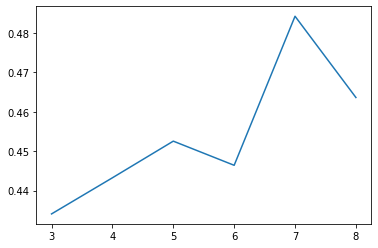

In [ ]:
plt.plot(topic_num, coherence)

In [ ]:
opt_num = 7
lda_model = gensim.models.LdaModel(corpus = bow_corpus,
                                        id2word = dictionary,
                                        num_topics = opt_num,
                                        offset = 2,
                                        random_state = 123,
                                        update_every = 1,
                                        passes = 10,
                                        alpha = 'auto',
                                        eta = "auto",
                                        per_word_topics = True)

In [ ]:
from pprint import pprint
pprint(lda_model.print_topics())

[(0,
  '0.034*"effect" + 0.032*"side" + 0.031*"feel" + 0.021*"day" + 0.021*"week" + '
  '0.017*"take" + 0.016*"start" + 0.016*"like" + 0.012*"first" + 0.011*"get"'),
 (1,
  '0.029*"took" + 0.027*"day" + 0.018*"hour" + 0.018*"pill" + 0.016*"take" + '
  '0.015*"work" + 0.013*"time" + 0.012*"go" + 0.010*"start" + 0.010*"water"'),
 (2,
  '0.031*"cramp" + 0.028*"period" + 0.022*"pain" + 0.020*"get" + 0.019*"month" '
  '+ 0.019*"day" + 0.019*"bleed" + 0.016*"got" + 0.012*"week" + '
  '0.012*"insert"'),
 (3,
  '0.018*"patch" + 0.018*"inject" + 0.017*"use" + 0.011*"drug" + 0.010*"insur" '
  '+ 0.009*"effect" + 0.008*"one" + 0.008*"tri" + 0.007*"cover" + '
  '0.007*"doctor"'),
 (4,
  '0.044*"weight" + 0.033*"month" + 0.028*"gain" + 0.018*"year" + 0.018*"pill" '
  '+ 0.015*"control" + 0.015*"pound" + 0.014*"start" + 0.013*"lost" + '
  '0.012*"lb"'),
 (5,
  '0.017*"year" + 0.017*"take" + 0.016*"anxieti" + 0.015*"life" + '
  '0.014*"medic" + 0.011*"work" + 0.011*"drug" + 0.011*"feel" + '
  '0.011*

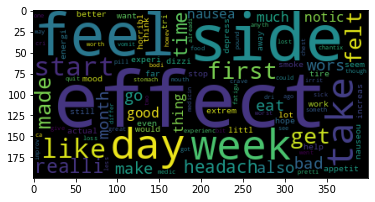

In [ ]:
# Plot WordCloud of 1st topic
plt.imshow(WordCloud().fit_words(dict(lda_model.show_topic(0, 100))))

In [ ]:
%%capture
# Compute Perplexity (lower is better)
perplexity = np.exp(lda_model.log_perplexity(bow_corpus))

# Compute Coherence Score (higher is better)
coherence_model_lda = CoherenceModel(model=lda_model, texts=reviews, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()

In [ ]:
print('Perplexity score: ', perplexity)
print('\n CV Coherence score: ', coherence_lda)

Perplexity score:  0.0010688052576387035

 CV Coherence score:  0.48422873078162026


## Visualizations

### Data preparation

In [ ]:
def find_topic(row, which = 0):
  idx = row['index']
  coherences = lda_model.__getitem__(bow=bow_corpus[idx], eps=0)[0]
  coherences = sorted(coherences, key = lambda x: x[1], reverse = True)
  return [coherences[which][0],coherences[which][1]]

In [ ]:
# See the most relevant topic for each review
data['index'] = [i for i in range(data.shape[0])]
data['top_topic'] = data.apply(lambda x: find_topic(x, which = 0)[0], axis = 1)
data['top_topic_probability'] = data.apply(lambda x: find_topic(x, which = 0)[1], axis = 1)

data.head()

,drugName,condition,review,rating,date,positiveness,drugClass,index,top_topic,top_topic_probability
0,trazodone,Insomnia,"""I have insomnia, it's horrible. My story begi...",10.0,"April 3, 2016",1,antidepressants,0,6,0.574351
1,fluvoxamine,Anxiety and Stress,"""I've suffered from panic attacks and anxiety ...",9.0,"January 3, 2011",1,antidepressants,1,5,0.776519
2,mirtazapine,Anxiety,"""Suffered from anxiety and depression for 3 mo...",10.0,"May 31, 2012",1,antidepressants,2,5,0.599468
3,trazodone,Depression,"""I take trazodone to help balance the effects ...",10.0,"June 1, 2016",1,antidepressants,3,6,0.610250
4,mirtazapine,Anxiety,"""I have taken this medicine for 7 years. Gaine...",10.0,"November 6, 2012",1,antidepressants,4,6,0.482181


### Topics distance

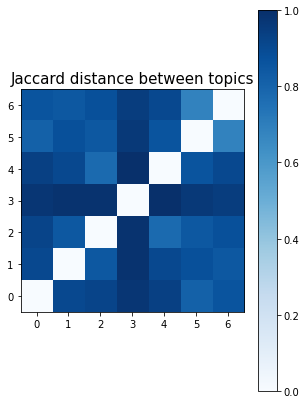

In [ ]:
mdiff, annotation = lda_model.diff(lda_model, distance='jaccard', num_words=50)
fig, ax = plt.subplots(figsize=(5,7))
graph = ax.imshow(mdiff, cmap='Blues', origin='lower')
plt.title('Jaccard distance between topics', fontsize = 15)
plt.colorbar(graph)

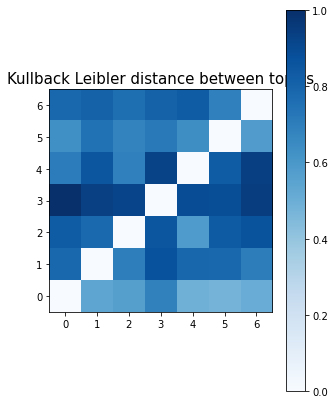

In [ ]:
mdiff, annotation = lda_model.diff(lda_model, distance='kullback_leibler', num_words=50)
fig, ax = plt.subplots(figsize=(5,7))
graph = ax.imshow(mdiff, cmap='Blues', origin='lower')
plt.title('Kullback Leibler distance between topics', fontsize = 15)
plt.colorbar(graph)

### pyLDAvis

In [ ]:
%%capture
!pip install pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import pickle 
import pyLDAvis
import os

In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, bow_corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.002651  0.070626       1        1  21.998756
0      0.073855  0.017734       2        1  16.838080
2      0.077168 -0.121573       3        1  15.833144
6     -0.003445  0.164314       4        1  15.708863
4      0.096677 -0.157960       5        1  13.946227
1      0.057433  0.090129       6        1  10.710201
3     -0.299038 -0.063269       7        1   4.964729, topic_info=         Term          Freq         Total Category  logprob  loglift
87     weight   8890.000000   8890.000000  Default  30.0000  30.0000
318      pain  12686.000000  12686.000000  Default  29.0000  29.0000
1766    cramp   7243.000000   7243.000000  Default  28.0000  28.0000
958   migrain   7192.000000   7192.000000  Default  27.0000  27.0000
59       gain   5770.000000   5770.000000  Default  26.0000  26.0000
...       ...           ...           ...      ...      ...      ...
333     howev    306.990645   2252.558696   Topic7  -5.4650   1.0098
117      side    345.643787  10482.693054   Topic7  -5.3465  -0.4093
134       bad    327.261890   6736.686962   Topic7  -5.4011  -0.0218
151     would    329.718034   9459.783085   Topic7  -5.3936  -0.3538
218     thing    304.148890   4882.731397   Topic7  -5.4743   0.2269

[513 rows x 6 columns], token_table=       Topic      Freq          Term
term                                
1287       1  1.000042       abilifi
3620       6  0.998631         abort
3490       6  0.998257          achi
4447       5  0.999691           acn
539        1  0.104971        actual
...      ...       ...           ...
89         7  0.005120          year
14500      5  1.000870  zolmitriptan
255        1  0.998942        zoloft
3641       4  0.999718         zomig
4043       5  0.999746       zyprexa

[1082 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 1, 3, 7, 5, 2, 4])

### t-SNE (1)

In [ ]:
# Credits to: https://stackoverflow.com/questions/60454355/draw-3d-plot-for-gensim-model

def LDA_tSNE_topics_vis(dimension='both',
                        corpus=None, 
                        num_topics=10,
                        remove_3d_outliers=False,
                        save_png=False):
    """
    Returns the outputs of an LDA model plotted using t-SNE (t-distributed Stochastic Neighbor Embedding)

    Note: t-SNE reduces the dimensionality of a space such that similar points will be closer and dissimilar points farther

    Parameters
    ----------
        dimension : str (default=both)
            The dimension that t-SNE should reduce the data to for visualization
            Options: 2d, 3d, and both (a plot with two subplots)

        corpus : list, list of lists
            The tokenized and cleaned text corpus over which analysis should be done

        num_topics : int (default=10)
            The number of categories for LDA based approaches

        remove_3d_outliers : bool (default=False)
            Whether to remove outliers from a 3d plot

        save_png : bool (default=False)
            Whether to save the figure as a png

    Returns
    -------
        A t-SNE lower dimensional representation of an LDA model's topics and their constituent members
    """
    # dirichlet_dict = corpora.Dictionary(reviews)
    # bow_corpus = [dirichlet_dict.doc2bow(text) for text in reviews]
    # dirichlet_model = LdaModel(corpus=bow_corpus,
    #                            id2word=dirichlet_dict,
    #                            num_topics=num_topics,
    #                            update_every=1,
    #                            chunksize=len(bow_corpus),
    #                            passes=10,
    #                            alpha='auto',
    #                            eta = 'auto',
    #                            random_state=123,
    #                            offset = 2,
    #                            per_word_topics = True)

    dirichlet_dict = dictionary
    dirichlet_model = lda_model

    df_topic_coherences = pd.DataFrame(columns = ['topic_{}'.format(i) for i in range(num_topics)])

    for i in range(len(bow_corpus)):
        df_topic_coherences.loc[i] = [0] * num_topics
        
        output = dirichlet_model.__getitem__(bow=bow_corpus[i], eps=0)
    
        for j in range(num_topics):
            _, coherence = output[0][j]
            df_topic_coherences.iloc[i, j] = coherence

    for i in range(num_topics):
        df_topic_coherences.iloc[:, i] = df_topic_coherences.iloc[:, i].astype('float64', copy=False)

    df_topic_coherences['main_topic'] = df_topic_coherences.iloc[:, :num_topics].idxmax(axis=1)

    if num_topics > 10:
        # cubehelix better for more than 10 colors
        colors = sns.color_palette("cubehelix", num_topics)
    else:
        # The default sns color palette
        colors = sns.color_palette('deep', num_topics)

    tsne_2 = None
    tsne_3 = None
    if dimension == 'both':
        tsne_2 = TSNE(n_components=2, perplexity=40, n_iter=300)
        tsne_3 = TSNE(n_components=3, perplexity=40, n_iter=300)
    elif dimension == '2d':
        tsne_2 = TSNE(n_components=2, perplexity=40, n_iter=300)
    elif dimension == '3d':
        tsne_3 = TSNE(n_components=3, perplexity=40, n_iter=300)
    else:
        ValueError("An invalid value has been passed to the 'dimension' argument - choose from 2d, 3d, or both.")

    if tsne_2 is not None:
        tsne_results_2 = tsne_2.fit_transform(df_topic_coherences.iloc[:, :num_topics])
        
        df_tsne_2 = pd.DataFrame()
        df_tsne_2['tsne-2d-d1'] = tsne_results_2[:,0]
        df_tsne_2['tsne-2d-d2'] = tsne_results_2[:,1]
        df_tsne_2['main_topic'] = df_topic_coherences.iloc[:, num_topics]
        df_tsne_2['color'] = [colors[int(t.split('_')[1])] for t in df_tsne_2['main_topic']]

        df_tsne_2['topic_num'] = [int(i.split('_')[1]) for i in df_tsne_2['main_topic']]
        df_tsne_2 = df_tsne_2.sort_values(['topic_num'], ascending = True).drop('topic_num', axis=1)
    
    if tsne_3 is not None:
        colors = [c for c in sns.color_palette()]

        tsne_results_3 = tsne_3.fit_transform(df_topic_coherences.iloc[:, :num_topics])
        
        df_tsne_3 = pd.DataFrame()
        df_tsne_3['tsne-3d-d1'] = tsne_results_3[:,0]
        df_tsne_3['tsne-3d-d2'] = tsne_results_3[:,1]
        df_tsne_3['tsne-3d-d3'] = tsne_results_3[:,2]
        df_tsne_3['main_topic'] = df_topic_coherences.iloc[:, num_topics]
        df_tsne_3['color'] = [colors[int(t.split('_')[1])] for t in df_tsne_3['main_topic']]

        df_tsne_3['topic_num'] = [int(i.split('_')[1]) for i in df_tsne_3['main_topic']]
        df_tsne_3 = df_tsne_3.sort_values(['topic_num'], ascending = True).drop('topic_num', axis=1)

        if remove_3d_outliers:
            # Remove those rows with values that are more than three standard deviations from the column mean
            for col in ['tsne-3d-d1', 'tsne-3d-d2', 'tsne-3d-d3']:
                df_tsne_3 = df_tsne_3[np.abs(df_tsne_3[col] - df_tsne_3[col].mean()) <= (3 * df_tsne_3[col].std())]

    if tsne_2 is not None and tsne_3 is not None:
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, # pylint: disable=unused-variable
                                       figsize=(20,10))
        ax1.axis('off')

    else:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))

    if tsne_2 is not None and tsne_3 is not None:
        # Plot tsne_2, with tsne_3 being added later
        ax1 = sns.scatterplot(data=df_tsne_2, x="tsne-2d-d1", y="tsne-2d-d2",
                              hue=df_topic_coherences.iloc[:, num_topics], alpha=0.3)
        
        light_grey_tup = (242/256, 242/256, 242/256)
        ax1.set_facecolor(light_grey_tup)
        ax1.axes.set_title('t-SNE 2-Dimensional Representation', fontsize=25)
        ax1.set_xlabel('tsne-d1', fontsize=20)
        ax1.set_ylabel('tsne-d2', fontsize=20)

        handles, labels = ax1.get_legend_handles_labels()
        legend_order = list(np.argsort([i.split('_')[1] for i in labels]))
        ax1.legend([handles[i] for i in legend_order], [labels[i] for i in legend_order], 
                   facecolor=light_grey_tup)

    elif tsne_2 is not None:
        # Plot just tsne_2
        ax = sns.scatterplot(data=df_tsne_2, x="tsne-2d-d1", y="tsne-2d-d2",
                             hue=df_topic_coherences.iloc[:, num_topics], alpha=0.3)

        ax.set_facecolor(light_grey_tup)
        ax.axes.set_title('t-SNE 2-Dimensional Representation', fontsize=25)
        ax.set_xlabel('tsne-d1', fontsize=20)
        ax.set_ylabel('tsne-d2', fontsize=20)

        handles, labels = ax.get_legend_handles_labels()
        legend_order = list(np.argsort([i.split('_')[1] for i in labels]))
        ax.legend([handles[i] for i in legend_order], [labels[i] for i in legend_order], 
                  facecolor=light_grey_tup)

    if tsne_2 is not None and tsne_3 is not None:
        # tsne_2 has been plotted, so add tsne_3
        ax2 = fig.add_subplot(121, projection='3d')
        ax2.scatter(xs=df_tsne_3['tsne-3d-d1'], 
                    ys=df_tsne_3['tsne-3d-d2'], 
                    zs=df_tsne_3['tsne-3d-d3'],  
                    c=df_tsne_3['color'],
                    alpha=0.3)

        ax2.set_facecolor('white')
        ax2.axes.set_title('t-SNE 3-Dimensional Representation', fontsize=25)
        ax2.set_xlabel('tsne-d1', fontsize=20)
        ax2.set_ylabel('tsne-d2', fontsize=20)
        ax2.set_zlabel('tsne-d3', fontsize=20)

        with plt.rc_context({"lines.markeredgewidth" : 0}):
            # Add handles via blank lines and order their colors to match tsne_2
            proxy_handles = [Line2D([0], [0], linestyle="none", marker='o', markersize=8,
                                    markerfacecolor=colors[i]) for i in legend_order]
            ax2.legend(proxy_handles, ['topic_{}'.format(i) for i in range(num_topics)], 
                       loc='upper left', facecolor=(light_grey_tup))

    elif tsne_3 is not None:
        # Plot just tsne_3
        ax.axis('off')
        ax.set_facecolor('white')
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(xs=df_tsne_3['tsne-3d-d1'], 
                   ys=df_tsne_3['tsne-3d-d2'], 
                   zs=df_tsne_3['tsne-3d-d3'],  
                   c=df_tsne_3['color'],
                   alpha=0.3)

        ax.set_facecolor('white')
        ax.axes.set_title('t-SNE 3-Dimensional Representation', fontsize=25)
        ax.set_xlabel('tsne-d1', fontsize=20)
        ax.set_ylabel('tsne-d2', fontsize=20)
        ax.set_zlabel('tsne-d3', fontsize=20)

        with plt.rc_context({"lines.markeredgewidth" : 0}):
            # Add handles via blank lines
            proxy_handles = [Line2D([0], [0], linestyle="none", marker='o', markersize=8,
                                    markerfacecolor=colors[i]) for i in range(len(colors))]
            ax.legend(proxy_handles, ['topic_{}'.format(i) for i in range(num_topics)], 
                      loc='upper left', facecolor=light_grey_tup)

    if save_png:
        plt.savefig('LDA_tSNE_{}.png'.format(time.strftime("%Y%m%d-%H%M%S")), bbox_inches='tight', dpi=500)

    plt.show()

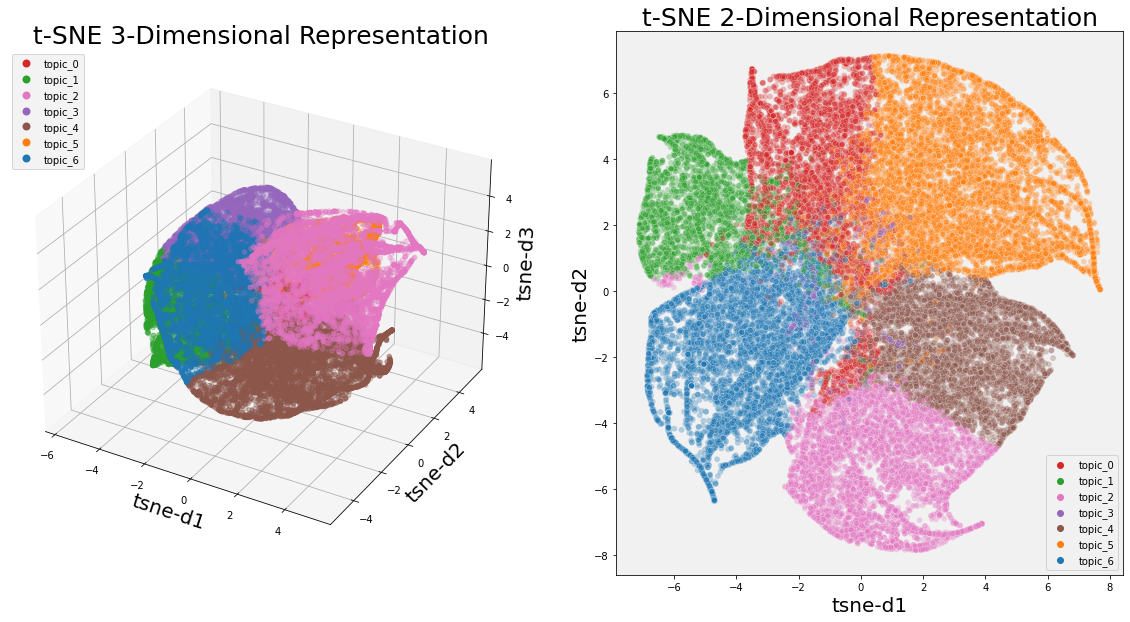

In [ ]:
LDA_tSNE_topics_vis(dimension='both',
                        corpus=None, 
                        num_topics=7,
                        remove_3d_outliers=False,
                        save_png=True)

### t-SNE (2)

In [ ]:
## Create document-topic matrix
doc_topic = pd.DataFrame(columns=['0','1','2','3','4','5','6'])
all = lda_model.get_document_topics(bow_corpus)
idx = 0
for doc_top in all:
  doc_top = {str(key):value for (key,value) in doc_top}
  doc_top = pd.DataFrame(doc_top, index = [idx])
  doc_topic = pd.concat([doc_topic,doc_top])
  idx += 1

# Fill NA values with 0
doc_topic = doc_topic.fillna(0)

In [ ]:
doc_topic.head()

,0,1,2,3,4,5,6
0,0.014950,0.000000,0.0,0.033796,0.000000,0.369202,0.574211
1,0.000000,0.117913,0.0,0.026932,0.070041,0.769410,0.000000
2,0.380930,0.000000,0.0,0.000000,0.000000,0.599458,0.000000
3,0.014571,0.000000,0.0,0.000000,0.000000,0.349904,0.610248
4,0.078551,0.000000,0.0,0.000000,0.262680,0.164505,0.482242


In [ ]:
%%capture
# t-SNE
from sklearn.manifold import TSNE
tsne_model = TSNE(n_components=2, verbose=1, random_state=7, angle=.99, init='pca', perplexity = 30)

# 7-D -> 2-D
tsne_lda = tsne_model.fit_transform(doc_topic) # doc_topic is document-topic matrix

In [ ]:
# Create dataframe for plotting t-SNE in R
l = len(tsne_lda[:,0])
data_tsne = pd.DataFrame({'x_tsne' : tsne_lda[:,0], 'y_tsne' : tsne_lda[:,1], 'row_id' : data['index'],
                          'x_1_topic_probability': data['top_topic_probability']})
for i in range(7):
  data_tsne[f'{i+1}_topic'] = doc_topic[f'{i}']

In [ ]:
data_tsne.head()

,x_tsne,y_tsne,row_id,x_1_topic_probability,1_topic,2_topic,3_topic,4_topic,5_topic,6_topic,7_topic
0,42.566063,37.103264,0,0.574351,0.014950,0.000000,0.0,0.033796,0.000000,0.369202,0.574211
1,56.103230,-15.610651,1,0.776519,0.000000,0.117913,0.0,0.026932,0.070041,0.769410,0.000000
2,28.423004,-56.030426,2,0.599468,0.380930,0.000000,0.0,0.000000,0.000000,0.599458,0.000000
3,44.376408,40.878326,3,0.610250,0.014571,0.000000,0.0,0.000000,0.000000,0.349904,0.610248
4,35.863930,33.692661,4,0.482181,0.078551,0.000000,0.0,0.000000,0.262680,0.164505,0.482242


In [ ]:
# Save dataframe
data_tsne.to_csv('data_tsne.csv')

# ... It continues on R! Please see README.md for instructions

### Topic - reviews relationships

In [ ]:
def conf_int_prop(row, conf, which):
  n = row['n']
  p = row['count']/n
  z = - scipy.stats.norm.ppf((1-conf)/2, 0, 1)
  lower = round(p - z*np.sqrt((p*(1-p))/n), 3)
  upper = round(p + z*np.sqrt((p*(1-p))/n), 3)
  if which == 'lower': return lower
  else: return upper

In [ ]:
conf = .999 # must be: 0 < conf < 1

In [ ]:
# Create confidence intervals for proportion (topic prevalence in positive ratings)
results = data.groupby(['top_topic', 'positiveness'], as_index = False).count()[['top_topic', 'positiveness', 'index']].rename({'index':'count', 'top_topic' : 'topic'}, axis = 1)
n = results.groupby(['topic'], as_index = False).sum()[['topic', 'count']].rename({'count':'n'}, axis = 1)
results = pd.merge(results, n, how = 'left', on = ['topic'])
results['p'] = results.apply(lambda x: round(x['count']/x['n'], 3), axis =1)
results['lower'] = results.apply(lambda x: conf_int_prop(x, conf, 'lower'), axis = 1)
results['upper'] = results.apply(lambda x: conf_int_prop(x, conf, 'upper'), axis = 1)

# Filter positive topics
results = results[results['positiveness'] == 1]

# Rename topics
results['topic'] = results['topic'].apply(lambda x: x+1)

results.head()

,topic,positiveness,count,n,p,lower,upper
1,1,1,2082,5250,0.397,0.374,0.419
3,2,1,2057,3315,0.621,0.593,0.648
5,3,1,2830,5612,0.504,0.482,0.526
7,4,1,155,393,0.394,0.313,0.476
9,5,1,2481,5396,0.460,0.437,0.482


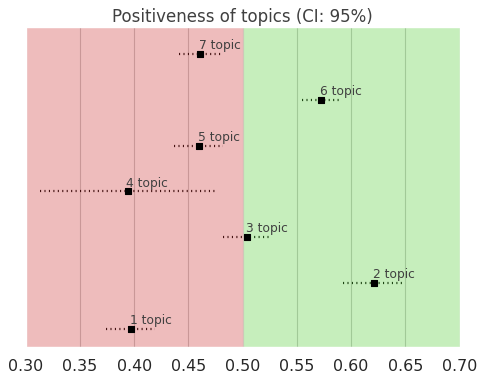

In [ ]:
# Plot style
from matplotlib.patches import Rectangle
plt.style.use('classic')
sns.set(rc={'axes.facecolor':'#ebebeb','figure.facecolor':'white','figure.figsize':(7, 5)}, font_scale=1.3)  
fig, ax = plt.subplots()
plt.grid(color='#bdbdbd')
ax.set_title("Positiveness of topics (CI: 95%)", size=15, color = '#404040')

# Plot
plt.scatter('p', 'topic', data = results,
         color = 'black', s = 37, marker = 's', zorder = 2)
plt.hlines('topic', 'lower', 'upper', data = results,
           colors='black', linestyles = 'dotted', linewidth = 2, zorder = 1, alpha = 0.9)
ax.add_patch(Rectangle((0.5,0), 1, 9, facecolor = '#35fc03', alpha = 0.2))
ax.add_patch(Rectangle((0,0), 0.5, 9, facecolor = '#fc0303', alpha = 0.2))


# Annotate
annotation = results.copy()
annotation['topic_string'] = annotation['topic'].apply(lambda x: f'{x} topic')
annotation = pd.DataFrame(annotation.set_index('topic_string')[['p','topic']])
for k, v in annotation.iterrows():
    plt.annotate(k, v,
                 xytext=(-1,5), textcoords='offset points', fontsize=11, color='#404040')
plt.xlim((0.3, 0.7))
plt.ylim((0.6, 7.6))
plt.yticks([])

plt.savefig('LDA_positivity_total.png', dpi = 300, bbox_inches = 'tight')

In [ ]:
# Create confidence intervals for proportion (topic prevalence in positive rating for each drugClass)
results = data.groupby(['top_topic', 'positiveness', 'drugClass'], as_index = False).count()[['top_topic','drugClass', 'positiveness', 'index']].rename({'index':'count', 'top_topic' : 'topic'}, axis = 1)
n = results.groupby(['topic', 'drugClass'], as_index = False).sum()[['topic', 'drugClass','count']].rename({'count':'n'}, axis = 1)
results = pd.merge(results, n, how = 'left', on = ['topic', 'drugClass'])
results['p'] = results.apply(lambda x: round(x['count']/x['n'], 3), axis =1)
results['lower'] = results.apply(lambda x: conf_int_prop(x, conf, 'lower'), axis = 1)
results['upper'] = results.apply(lambda x: conf_int_prop(x, conf, 'upper'), axis = 1)

# Filter positive topics
results = results[results['positiveness'] == 1]

# Rename topics
results['topic'] = results['topic'].apply(lambda x: x+1)

results

,topic,drugClass,positiveness,count,n,p,lower,upper
14,1,anorexiants,1,245,570,0.430,0.362,0.498
15,1,antidepressants,1,917,2133,0.430,0.395,0.465
16,1,antimigraine-agents,1,5,32,0.156,-0.055,0.367
17,1,atypical-antipsychotics,1,138,371,0.372,0.289,0.455
18,1,cns-stimulants,1,71,196,0.362,0.249,0.475
...,...,...,...,...,...,...,...,...
185,7,miscellaneous-analgesics,1,864,1722,0.502,0.462,0.541
186,7,miscellaneous-anxiolytics-sedatives-and-hypnotics,1,363,982,0.370,0.319,0.420
187,7,nonsteroidal-anti-inflammatory-agents,1,358,667,0.537,0.473,0.600
188,7,skeletal-muscle-relaxants,1,343,633,0.542,0.477,0.607


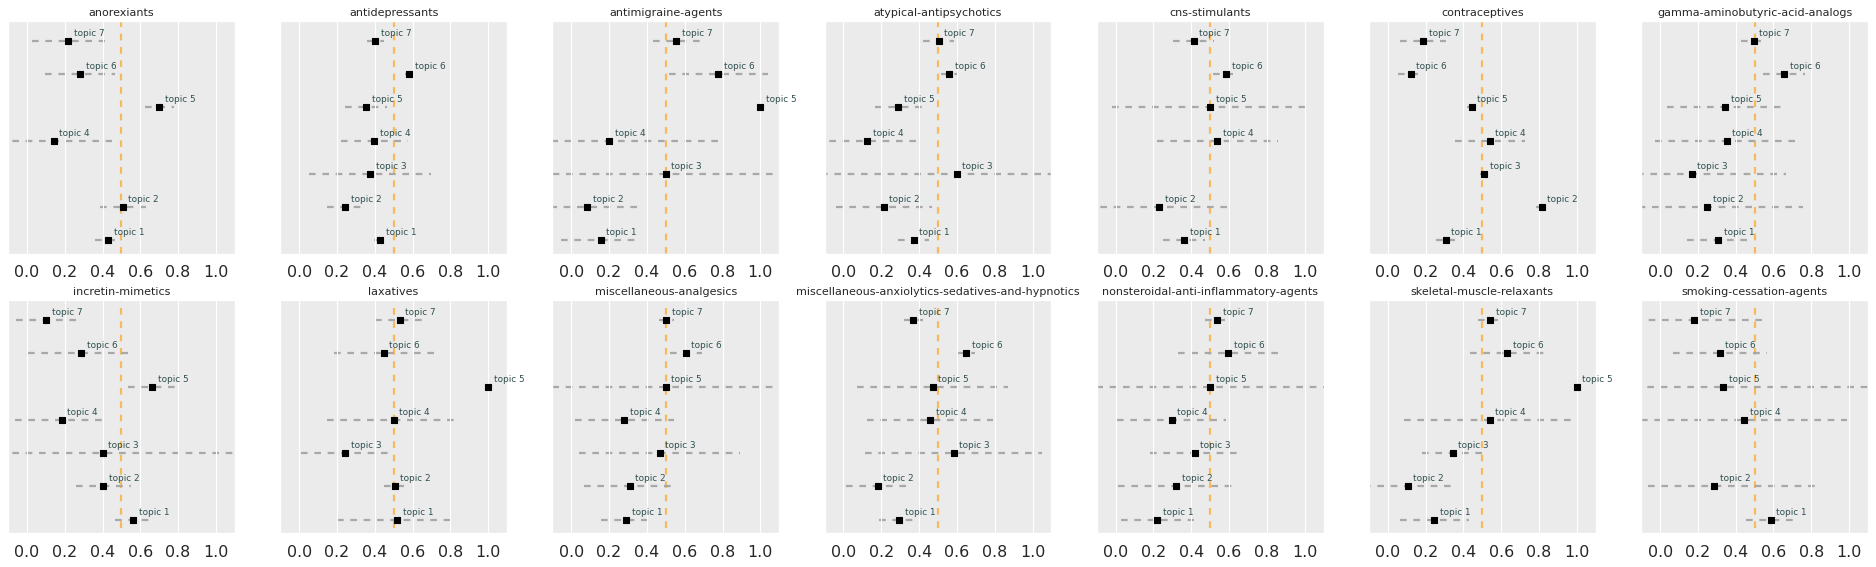

In [ ]:
# Plots
fig, axs = plt.subplots(2, 7, figsize = (30, 8))
i, j = 0, 0
for c in np.unique(results['drugClass']):
  df = results[results['drugClass'] == c]
  axs[i, j].scatter('p', 'topic', data = df,
         color = 'black', s = 35, marker = 's', zorder = 1)
  axs[i, j].hlines('topic', 'lower', 'upper', data = df,
           colors='#a8a8a8', linestyles = 'dashed', linewidth = 2, zorder = 0)
  axs[i, j].vlines(0.5, -1, 8,
           colors='#ff9900', linestyles = 'dashed', linewidth = 2, zorder = -1, alpha = 0.6)
  axs[i, j].set_title(f"{c}", fontsize = 10)
  axs[i, j].set_xlim((-0.1, 1.1))
  axs[i, j].set_ylim((0.6, 7.6))
  axs[i, j].set_yticks([])

  # annotation
  annotation = df.copy()
  annotation['topic_string'] = annotation['topic'].apply(lambda x: f'topic {x}')
  annotation = pd.DataFrame(annotation.set_index('topic_string')[['p','topic']])
  for k, v in annotation.iterrows():
      axs[i, j].annotate(k, v,
                  xytext=(5,5), textcoords='offset points',
                  family='sans-serif', fontsize=8, color='darkslategrey')
    
  j += 1
  if j == 7:
    i, j = 1, 0